In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath('/Users/novikov/python_notebooks/datatonic-challenge/utils')) #point this to the where util is relatively to your working directory
from util import *

In [5]:
import pandas as pd
pd.set_option('display.max_columns', None) #will show all columns, comment out if not interested, as it may make the notebook slow
import numpy as np
import json 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
import pickle

Loading preprocessed data in. Dropping the "id" column as it's not useful, "vote_average" and "vote_count" are also removed as this data would not be available pre-movie release. 

In [30]:
data_dir = get_path_to_data_dir()
plot_dir = get_path_to_plot_dir()
movie_data = pd.read_pickle(data_dir + 'pre-processed/movie_encoded_only_numeric.pkl')
movie_data = movie_data.drop(['id', 'vote_average', 'vote_count'], axis = 'columns') #dropping features which won't be available before movie release

The numerical features (budget, revenue, runtime, release_date) need to be normalised and fit within the 0-1 range. A cube root normalisation is used, as it provides the best results after also trying min-max scaler (just scaling data to range), log scaling, or fitting the data to have 0 mean and unit variance. 

In [7]:
def normalize_cube_root(y_cube):
    movie_data.budget**(1/3)
    y_cube = normalize(y_log)
    return y_log_norm

def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

def feature_scaling(column, df):
    cube_root = df[column]**(1/3)
    cube_norm = normalize(cube_root)
    df[column] = cube_norm
    return df

columns_to_scale = ['budget', 'revenue', 'runtime', 'release_date']
for column in columns_to_scale:
    movie_data = feature_scaling(column, movie_data)

Check that the transformed data makes sense

In [8]:
movie_data.describe()

budget      revenue      runtime  release_date    lead_male  \
count  3074.000000  3074.000000  3074.000000   3074.000000  3074.000000   
mean      0.535429     0.441656     0.610748      0.739192     0.729993   
std       0.198420     0.208755     0.118027      0.211543     0.444035   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.404359     0.288359     0.522210      0.607269     0.000000   
50%       0.526473     0.427197     0.594727      0.804338     1.000000   
75%       0.678602     0.588256     0.688888      0.899122     1.000000   
max       1.000000     1.000000     1.000000      1.000000     1.000000   

       lead_female   lead2_male  lead2_female       Action    Adventure  \
count  3074.000000  3074.000000   3074.000000  3074.000000  3074.000000   
mean      0.241054     0.559206      0.386467     0.259597     0.169811   
std       0.427793     0.496563      0.487019     0.438485     0.375528   
min       0.000000     0.000000      0.000000     0.000000     0.000000   
25%       0.000000     0.000000      0.000000     0.000000     0.000000   
50%       0.000000     1.000000      0.000000     0.000000     0.000000   
75%       0.000000     1.000000      1.000000     1.000000     0.000000   
max       1.000000     1.000000      1.000000     1.000000     1.000000   

         Animation       Comedy        Crime  Documentary        Drama  \
count  3074.000000  3074.000000  3074.000000  3074.000000  3074.000000   
mean      0.048796     0.365647     0.165908     0.014964     0.462264   
std       0.215477     0.481690     0.372058     0.121429     0.498655   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Family      Fantasy      Foreign      History       Horror  \
count  3074.000000  3074.000000  3074.000000  3074.000000  3074.000000   
mean      0.103774     0.091412     0.001952     0.040013     0.109629   
std       0.305016     0.288241     0.044144     0.196022     0.312478   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             Music      Mystery      Romance  Science Fiction  TV Movie  \
count  3074.000000  3074.000000  3074.000000      3074.000000    3074.0   
mean      0.039037     0.082303     0.189980         0.116461       0.0   
std       0.193715     0.274871     0.392349         0.320829       0.0   
min       0.000000     0.000000     0.000000         0.000000       0.0   
25%       0.000000     0.000000     0.000000         0.000000       0.0   
50%       0.000000     0.000000     0.000000         0.000000       0.0   
75%       0.000000     0.000000     0.000000         0.000000       0.0   
max       1.000000     1.000000     1.000000         1.000000       0.0   

          Thriller          War      Western        1960s        1970s  \
count  3074.000000  3074.000000  3074.000000  3074.000000  3074.000000   
mean      0.292453     0.033182     0.017241     0.004880     0.008783   
std       0.454963     0.179139     0.130191     0.069695     0.093322   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000 

The data is then split into the targe (Y) and features (X). It is then split into training and testing data, with 80/20 split.

In [9]:
Y = (movie_data['revenue'])
X = movie_data.drop(['revenue'], axis = 'columns')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

## Model training and predictions

A number of models is trained and evaluated by using R^2 score. The implementation is ordered by how well we expected the models to perform before training.

Recursive feature selection (RFE) is used in for the top 2 models in order to perform feature selection. Number of needed features was determined experimentally.

#### Ridge Regression

In [10]:
def train_ridge(X_train, Y_train, X_test, Y_test):
    ridge = Ridge(alpha = 15)
    selector = RFE(ridge, 500, step = 20)
    X_train_fs = selector.fit_transform(X_train, Y_train)
    X_test_fs = selector.transform(X_test)
    ridge.fit(X_train_fs, Y_train)
    pred_ridge1 = ridge.predict(X_test_fs)
    pred_ridge = selector.predict(X_test)
    print('R^2 for ridge regression: {:.3f}'.format(r2_score(Y_test, pred_ridge1)))
    return ridge, r2_score(Y_test, pred_ridge1)
    
    
ridge_model, r2_ridge = train_ridge(X_train, Y_train, X_test, Y_test)

R^2 for ridge regression: 0.527


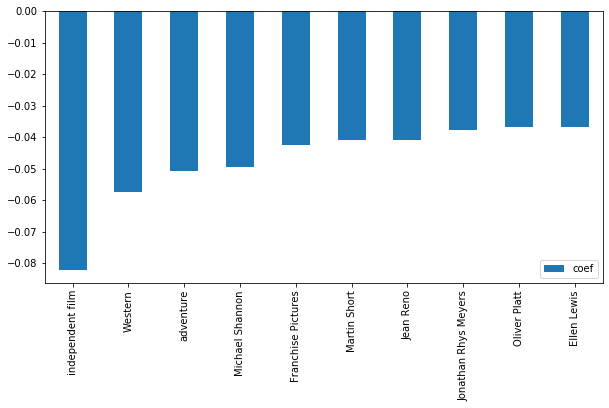

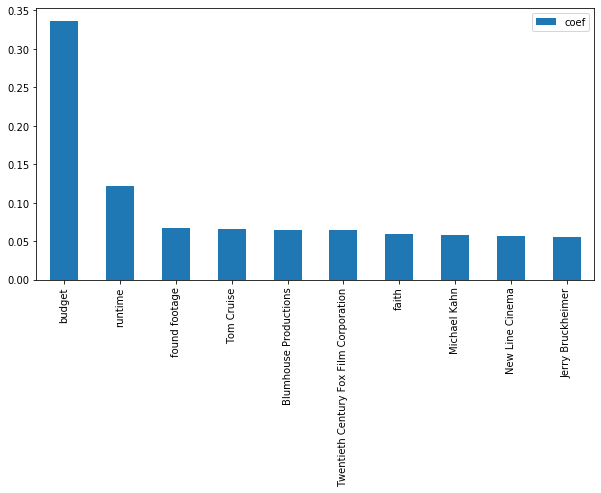

In [32]:
def plot_ridge_importance(X_train, Y_train, X_test, Y_test, save = True):
    ridge = Ridge(alpha = 15)
    ridge.fit(X_train, Y_train)
    ridge_coefs = list(ridge.coef_)
    index = X.columns
    feat_imp_ridge = pd.DataFrame({'coef': ridge_coefs}, index = index) #this used to have more columns, that's why it's a dataframe

    best_feat_ridge = feat_imp_ridge.sort_values(by=['coef'], ascending=False)
    worst_feat_ridge = best_feat_ridge.sort_values(by=['coef'])
    top10_ridge = best_feat_ridge.iloc[:10, :]
    bottom10_ridge = worst_feat_ridge.iloc[:10, :]
    
    bottom10_ridge_plot = bottom10_ridge.plot.bar(y = 'coef', figsize=(10,5))
    top10_ridge_plot = top10_ridge.plot.bar(y = 'coef', figsize = (10,5))
    bototm10_ridge_fig = bottom10_ridge_plot.get_figure()
    top10_ridge_fig = top10_ridge_plot.get_figure()
    if save:
        bototm10_ridge_fig.savefig(plot_dir+'/bottom10_features_ridge.png', dpi = 300, bbox_inches='tight')
        top10_ridge_fig.savefig(plot_dir+'/top10_features_ridge.png', dpi = 300, bbox_inches='tight')
    
    
plot_ridge_importance(X_train, Y_train, X_test, Y_test, save = True)

#### Elastic Net

In [33]:
def train_elastic(X_train, Y_train, X_test, Y_test, save = True, save_dir = None):
    elastic = ElasticNet(alpha = 0.001, l1_ratio = 0.2)
    selector_elastic = RFE(elastic, 500, step = 100)
    X_train_fs = selector_elastic.fit_transform(X_train, Y_train)
    X_test_fs = selector_elastic.transform(X_test)
    elastic.fit(X_train_fs, Y_train)
    pred_elastic1 = elastic.predict(X_test_fs)
    pred_elastic = selector_elastic.predict(X_test)
    print('R^2 for elastic net: {:.3f}'.format(r2_score(Y_test, pred_elastic), r2_score(Y_test, pred_elastic1)))
    if save: 
        try:
            if save_dir is None:
                save_dir = os.getcwd()
            filename = save_dir + '/trained-models/' + 'elastic_net.pkl'
            pickle.dump(elastic, open(filename, 'wb'))
        except FileNotFoundError:
            print("couldn't save, check direcotry")
    return elastic, r2_score(Y_test, pred_elastic1)
    
elastic_net_model, r2_elastic = train_elastic(X_train, Y_train, X_test, Y_test)

R^2 for elastic net: 0.533


In [ ]:
def plot_elastic_importance(X_train, Y_train, X_test, Y_test, save = True):
    elastic = ElasticNet(alpha = 0.001, l1_ratio = 0.2)
    elastic.fit(X_train, Y_train)
    elastic_coefs = list(elastic.coef_)
    index = X.columns
    feat_imp_elastic = pd.DataFrame({'coef': elastic_coefs}, index = index)
    best_feat_elastic = feat_imp_elastic.sort_values(by=['coef'], ascending=False)
    worst_feat_elastic = best_feat_elastic.sort_values(by=['coef'])
    top10_elastic = best_feat_elastic.iloc[:10, :]
    bottom10_elastic = worst_feat_elastic.iloc[:10, :]

    bottom10_elastic_plot = bottom10_elastic.plot.bar(y = 'coef', figsize=(10,5))
    top10_elastic_plot = top10_elastic.plot.bar(y = 'coef', figsize = (10,5))
    for tick in top10_elastic_plot.get_xticklabels():
        tick.set_rotation(45)
    for tick in bottom10_elastic_plot.get_xticklabels():
        tick.set_rotation(45)
    bototm10_elastic_fig = bottom10_elastic_plot.get_figure()
    top10_elastic_fig = top10_elastic_plot.get_figure()

    if save:
        bototm10_elastic_fig.savefig(plot_dir+'/bottom10_features_elastic.png', dpi = 500, bbox_inches='tight')
        top10_elastic_fig.savefig(plot_dir+'/top10_features_elastic.png', dpi = 500, bbox_inches='tight')

plot_elastic_importance(X_train, Y_train, X_test, Y_test, save = True)

#### SVM (linear kernel)

In [21]:
def train_svm(X_train, Y_train, X_test, Y_test, save = True, save_dir = None):
    clf = SVR(kernel = 'linear', C=0.01, epsilon=0.002)
    clf.fit(X_train, Y_train)
    pred_clf = clf.predict(X_test)
    coefs_clf = clf.coef_
    print('R^2 for SVR with linear kernel: {:.3f}'.format(clf.score(X_test, Y_test), r2_score(Y_test, pred_clf)))
    if save: 
        try:
            if save_dir is None:
                save_dir = os.getcwd()
            filename = save_dir + '/trained-models/' + 'svm.pkl'
            pickle.dump(clf, open(filename, 'wb'))
        except FileNotFoundError:
            print("couldn't save, check direcotry")    
    return clf, r2_score(Y_test, pred_clf)
    
svm_model, r2_svm = train_svm(X_train, Y_train, X_test, Y_test)

R^2 for SVR with linear kernel: 0.491


#### XGBoost

In [22]:
def train_xgboost(X_train, Y_train, X_test, Y_test, save = True, save_dir = None):
    xgb = XGBRegressor(booster = 'gbtree', eta = 0.1, min_child_weight = 3, max_delta_step = 3, subsample = 1, 
                       colsample_bytree = 0.75)
    xgb.fit(X_train, Y_train)
    pred_xgb = xgb.predict(X_test)
    print('R^2 for random forest regressor: {}'.format(r2_score(Y_test, pred_xgb)))
    if save: 
        try:
            if save_dir is None:
                save_dir = os.getcwd()
            filename = save_dir + '/trained-models/' + 'xgboost.pkl'
            pickle.dump(xgb, open(filename, 'wb'))
        except FileNotFoundError:
            print("couldn't save, check direcotry")
    return xgb, r2_score(Y_test, pred_xgb)

xgb_model, r2_xgb = train_xgboost(X_train, Y_train, X_test, Y_test)

R^2 for random forest regressor: 0.5291894818300308


#### Random Forest Regressor

In [23]:
def train_random_forest(X_train, Y_train, X_test, Y_test, save = True, save_dir = None):
    rand_for = RandomForestRegressor(n_estimators = 100)
    rand_for.fit(X_train, Y_train)
    pred_rand_for = rand_for.predict(X_test)
    
    print('R^2 for random forest regressor: {}'.format(r2_score(Y_test, pred_rand_for)))
    if save: 
        try:
            if save_dir is None:
                save_dir = os.getcwd()
            filename = save_dir + '/trained-models/' + 'random_forest.pkl'
            pickle.dump(rand_for, open(filename, 'wb'))
        except FileNotFoundError:
            print("couldn't save, check direcotry")
    
    return rand_for, r2_score(Y_test, pred_rand_for)

random_forest_model, r2_random_forest = train_random_forest(X_train, Y_train, X_test, Y_test)

R^2 for random forest regressor: 0.5019530675281865


#### Extra Trees Regressor

In [24]:
def train_extra_trees(X_train, Y_train, X_test, Y_test, save = True, save_dir = None):
    extra_tr = ExtraTreesRegressor(min_samples_split = 100)
    extra_tr.fit(X_train, Y_train)
    pred_extra_tr = extra_tr.predict(X_test)
    print('R^2 for extra trees regressor: {}'.format(r2_score(Y_test, pred_extra_tr)))
    if save: 
        try:
            if save_dir is None:
                save_dir = os.getcwd()
            filename = save_dir + '/trained-models/' + 'extra_trees.pkl'
            pickle.dump(extra_tr, open(filename, 'wb'))
        except FileNotFoundError:
            print("couldn't save, check direcotry")
    return extra_tr, r2_score(Y_test, pred_extra_tr)

extra_trees_model, r2_extra_trees = train_extra_trees(X_train, Y_train, X_test, Y_test)

R^2 for extra trees regressor: 0.46794691168549485


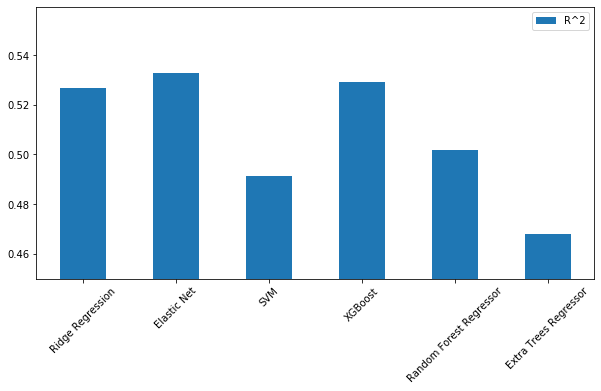

In [41]:
r2_scores = [r2_ridge, r2_elastic, r2_svm, r2_xgb, r2_random_forest, r2_extra_trees]
index = ['Ridge Regression', 'Elastic Net', 'SVM', 'XGBoost', 'Random Forest Regressor', 'Extra Trees Regressor']
r2_df = pd.DataFrame({'R^2': r2_scores}, index = index)
r2_df.to_pickle('/Users/novikov/python_notebooks/datatonic-challenge/ml-prediction/trained-models/r2_scores')
r2_plot = r2_df.plot.bar(y = 'R^2', figsize=(10,5), ylim = 0.45)
for tick in r2_plot.get_xticklabels():
    tick.set_rotation(45)
r2_fig = r2_plot.get_figure()
r2_fig.savefig(plot_dir+'/r2_scores.png', dpi = 500, bbox_inches='tight')